## EDA

In [39]:
!pip install konlpy
!apt-get update -qq
!apt-get install fonts-nanum* -qq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Selecting previously unselected package fonts-nanum-extra.
(Reading database ... 122519 files and directories currently installed.)
Preparing to unpack .../fonts-nanum-extra_20180306-3_all.deb ...
Unpacking fonts-nanum-extra (20180306-3) ...
Selecting previously unselected package fonts-nanum.
Preparing to unpack .../fonts-nanum_20180306-3_all.deb ...
Unpacking fonts-nanum (20180306-3) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-2_all.deb ...
Unpacking fonts-nanum-coding (2.5-2) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Setting up fonts-nanum-extra (20180306-3) ...
Setting up fonts-nanum (20180306-3) ...
Setting up fonts-nanum-coding (2.5-2) ...
Setting up fonts-nanum-eco (1.000-7) ...
Processing triggers 

In [29]:
import numpy as np
import torch.cuda
import torch
import json
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt 
import konlpy
from konlpy.tag import Okt
from collections import Counter
from wordcloud import WordCloud
from google.colab import drive
import stanza

In [3]:
konlpy.jvm.init_jvm(jvmpath=None, max_heap_size=4096)


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

drive.mount('/content/gdrive/')
#/content/gdrive/MyDrive/valid_set.json

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [8]:
path = '/content/gdrive/MyDrive/'
with open(f'{path}/train_set.json', 'r') as train:
            train = json.load(train)
with open(f'{path}/valid_set.json', 'r') as valid:
            valid = json.load(valid)


In [9]:
train_df = pd.json_normalize(train['data'])

In [10]:
train_df = train_df[['ko_original', 'en', 'domain']]

In [11]:
train_df.head()

,ko_original,en,domain
0,한 의료단체는 연방법원에 보건부 지침 취소를 요구하는 소송을 제기하기도 했다.,A medical group has even filed a federal court...,세계
1,특정 지역에서는 순위 변동이 크게 나타나고 있는 점에 주목해야 한다.,It should be noted that there are significant ...,경제
2,일본·중국·한국의 학자들이 참석해 개발학의 현황부터 유엔의 '2030 지속가능 개발...,"Scholars from Japan, China, and Korea will loo...",세계
3,"비교기(1235 및 1237)는 설정에 따라 Relu 활성함수로 나타낼 수 있으며,...",The comparators 1235 and 1237 may be expressed...,기술과학
4,이 프로그램은 도시 재생의 초점을 낙후 지역이나 불량 주택을 철거하기보다는 근린 지...,The program is credited with focusing urban re...,경제


In [13]:
valid_df = pd.json_normalize(valid['data'])

In [14]:
valid_df = valid_df[['ko_original', 'en', 'domain']]

In [15]:
valid_df.head()

,ko_original,en,domain
0,상기 제1 지점 및 상기 제2 지점은 표시 장치(160) 내에 위치하는 서로 상이한...,The first point and the second point may inclu...,기술과학
1,탐색 학습 또한 기업의 경영 성과에 정의 영향을 미칠 것이다.,Exploratory learning will also have a definiti...,경제
2,자국과 자유 무역 협정이 체결되지 않은 국가들로부터 수입된 완성차와 자국에 생산 시...,High tariffs in the range of 20% to 40% are ap...,경제
3,만일 이를 인정한다면 소비자의 의사에 기하지 않은 의무(반송 의무)가 사업자의 일방...,"If this is acknowledged, there will arise a pr...",경제
4,위임장 권유 절차는 주주 총회의 소집 절차와 매우 유사한 방식이나 소집 절차와 동시...,The proxy solicitation process is very similar...,경제


In [16]:
#데이터구조 파악
print(train_df.shape)
print(valid_df.shape)

(1200144, 3)
(150018, 3)


In [17]:
#domain  분류
t_values = train_df['domain'].value_counts()
v_values = valid_df['domain'].value_counts()
print('train_df 도메인 분류')
print(t_values)
print('valid_df 도메인 분류')
print(v_values)

train_df 도메인 분류
세계      400123
기술과학    319551
경제      240439
정치      160064
기후       79967
Name: domain, dtype: int64
valid_df 도메인 분류
세계      49818
기술과학    40359
경제      29705
정치      20175
기후       9961
Name: domain, dtype: int64


### 글자 평균 길이

In [18]:
korean_len_mean = np.mean(train_df['ko_original'].str.len())
print('실제 한국어 Text 평균 길이 :',korean_len_mean)
english_len_mean = np.mean(train_df['en'].str.len())
print('실제 한국어 Text 평균 길이 :',english_len_mean)

실제 한국어 Text 평균 길이 : 78.0933429655108
실제 한국어 Text 평균 길이 : 178.4621728725886


In [19]:
#domain 분류
mask_world = (train_df.domain == '세계')
mask_science = (train_df.domain == '기술과학')
mask_economy = (train_df.domain == '경제')
mask_politics = (train_df.domain == '정치')
mask_weather = (train_df.domain == '기후')

df_train = train_df.ko_original.copy()

df_world = train_df.loc[mask_world,:].ko_original
df_science = train_df.loc[mask_science,:].ko_original
df_economy = train_df.loc[mask_economy,:].ko_original
df_politics = train_df.loc[mask_politics,:].ko_original
df_weather = train_df.loc[mask_weather,:].ko_original


In [20]:
compare = [df_train, df_world, df_science, df_economy, df_politics, df_weather]

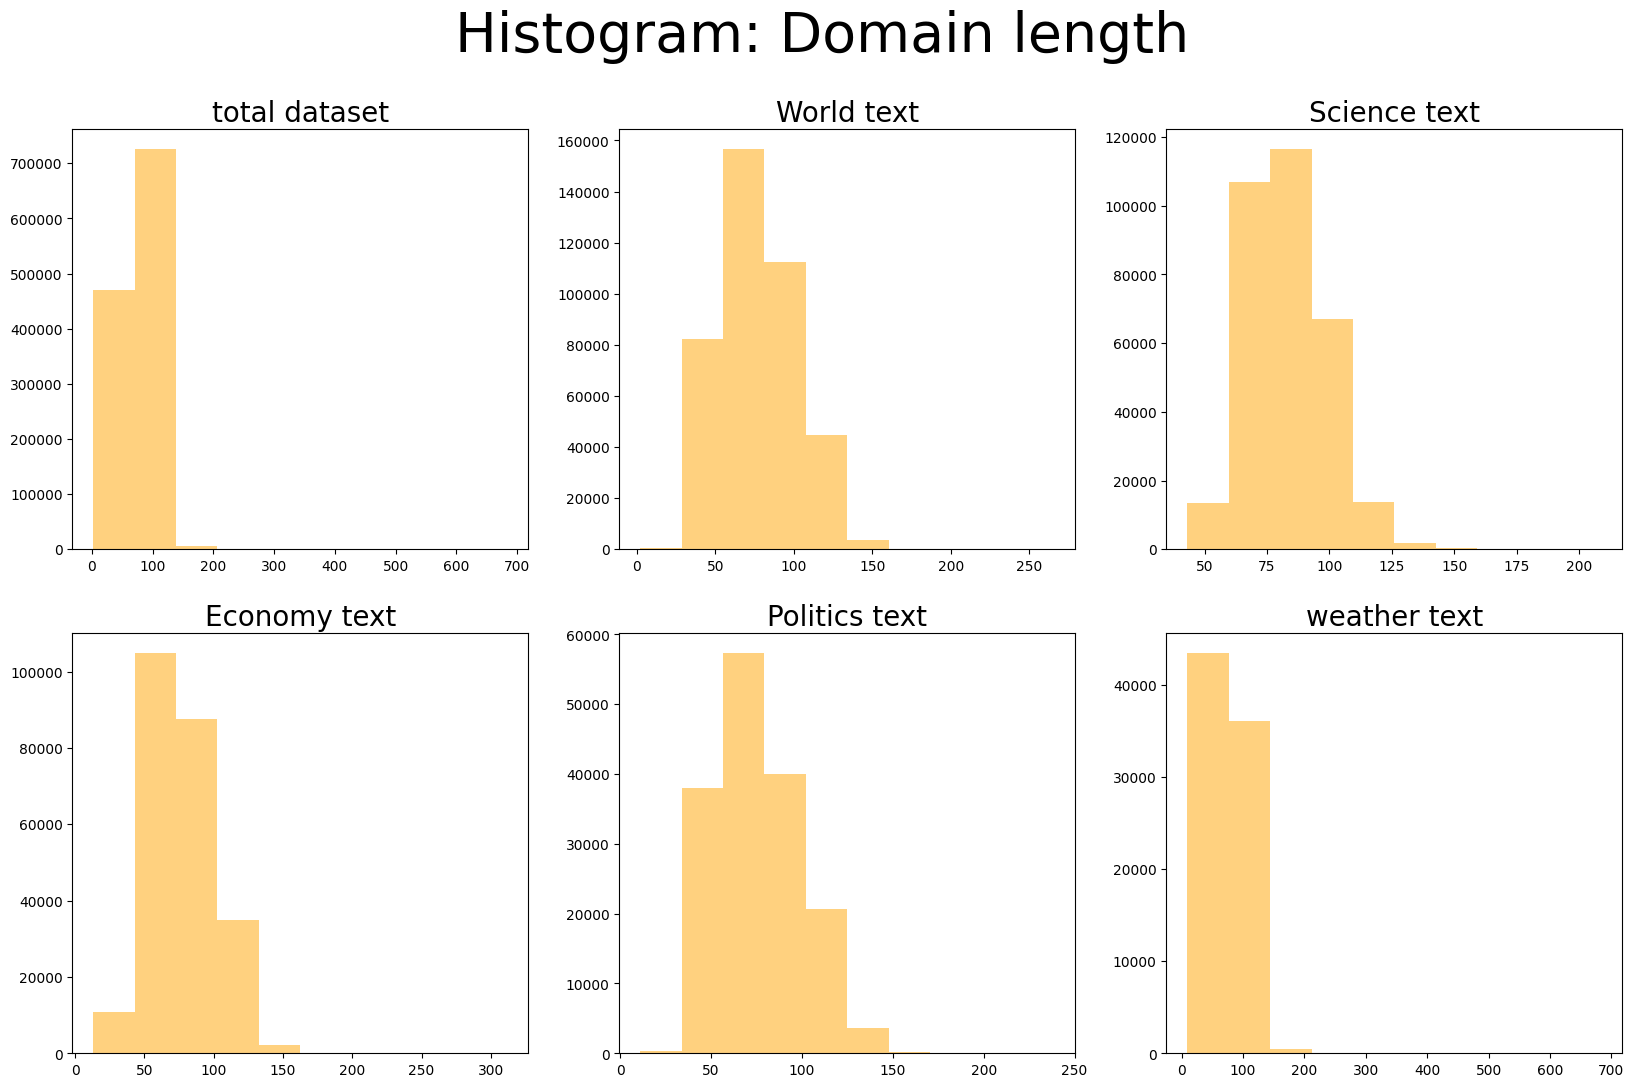

In [21]:
# 히스토그램 을 사용
plt.figure(figsize=(20,12))
plt.suptitle("Histogram: Domain length", fontsize=40)
name = ['total dataset', 'World text', 'Science text', 'Economy text', 'Politics text', 'weather text']

for i in range(len(compare)):
    document = compare[i]
    string_len = [len(x) for x in document]

    plt.subplot(2, 3, i+1)
    plt.title(name[i], fontsize=20)
    plt.hist(string_len, alpha=0.5, color='orange') 
    
plt.show()

In [22]:
#domain 분류
mask_world = (valid_df.domain == '세계')
mask_science = (valid_df.domain == '기술과학')
mask_economy = (valid_df.domain == '경제')
mask_politics = (valid_df.domain == '정치')
mask_weather = (valid_df.domain == '기후')

df_valid= valid_df.en.copy()

df_world = valid_df.loc[mask_world,:].en
df_science = valid_df.loc[mask_science,:].en
df_economy = valid_df.loc[mask_economy,:].en
df_politics = valid_df.loc[mask_politics,:].en
df_weather = valid_df.loc[mask_weather,:].en


In [23]:
compare = [df_valid, df_world, df_science, df_economy, df_politics, df_weather]

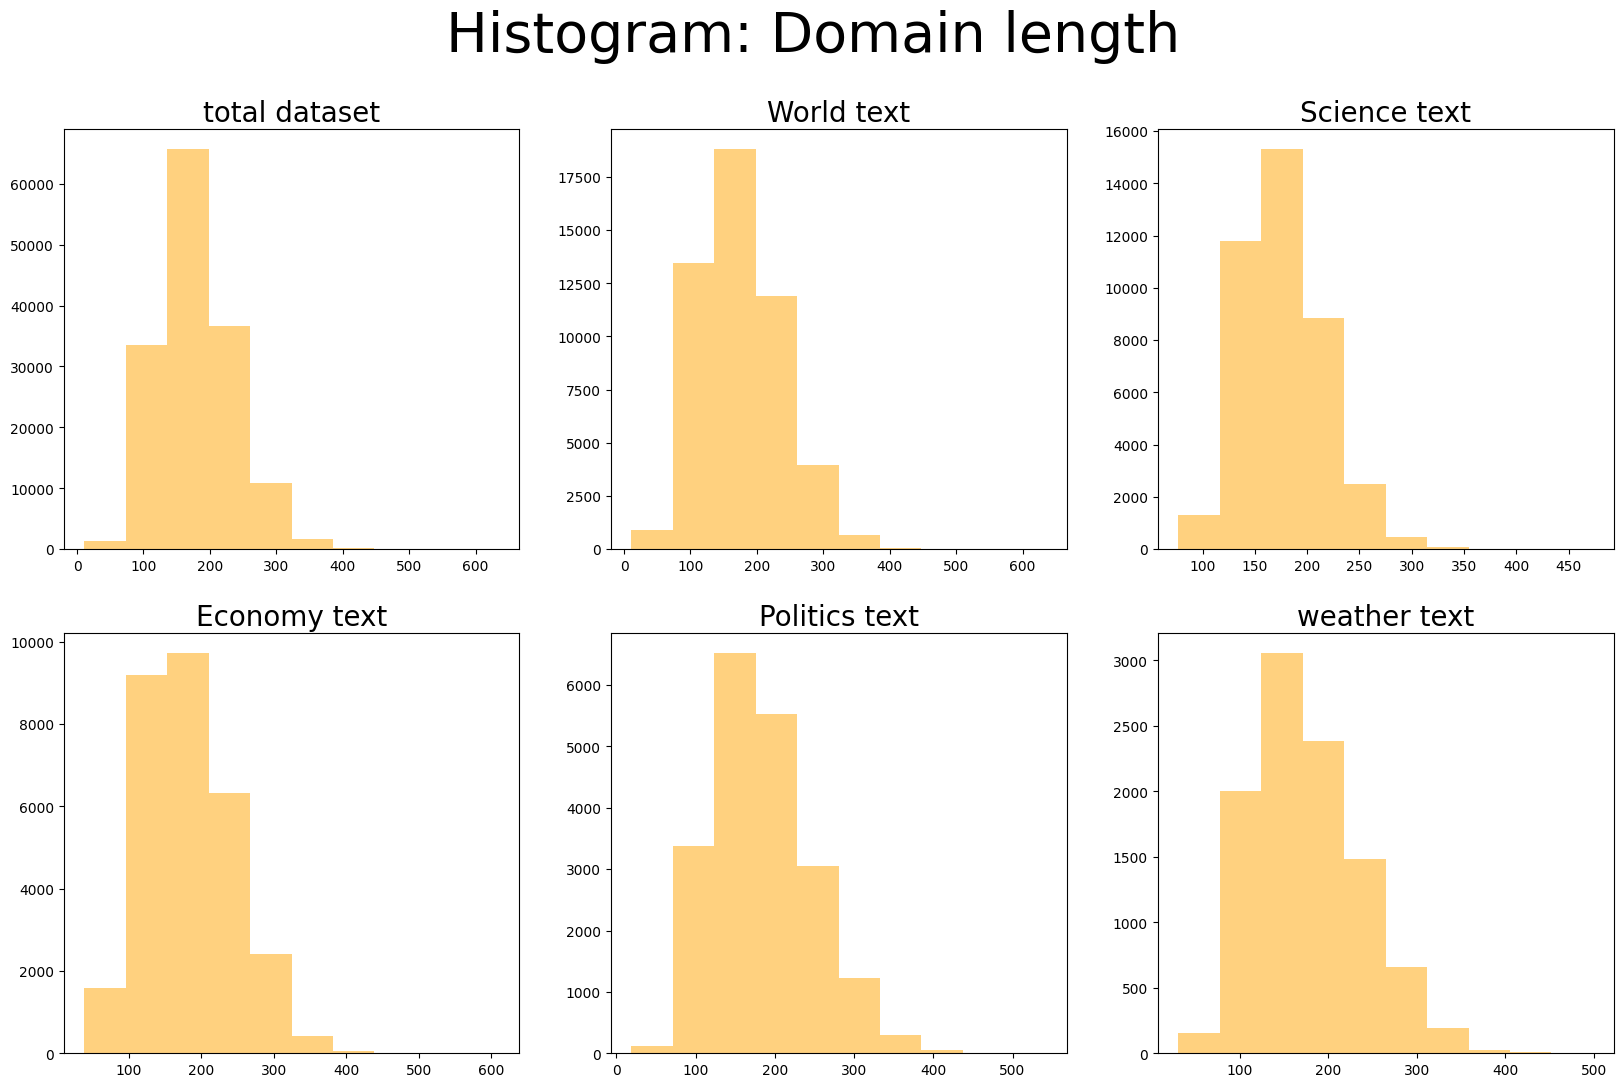

In [24]:
# 히스토그램 을 사용
plt.figure(figsize=(20,12))
plt.suptitle("Histogram: Domain length", fontsize=40)
name = ['total dataset', 'World text', 'Science text', 'Economy text', 'Politics text', 'weather text']

for i in range(len(compare)):
    document = compare[i]
    string_len = [len(x) for x in document]

    plt.subplot(2, 3, i+1)
    plt.title(name[i], fontsize=20)
    plt.hist(string_len, alpha=0.5, color='orange') 
    
plt.show()

### Word Cloud

In [34]:
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [36]:
def df2str(df):
    #전체 리뷰들을 하나의 문자열로 만들기
    s = [s for s in df]
    document = ""
    for i in range(len(s)):
        document += s[i]
    return document

def get_noun(text):
    okt = Okt()
    noun = okt.nouns(text)
    for i,v in enumerate(noun):
        if len(v)<2:
            noun.pop(i)
    count = Counter(noun)
    noun_list = count.most_common(100)

    return noun_list


def visualize(noun_list, title):
    # 워드클라우드 이미지 생성
    wc= WordCloud(
        background_color='white',                          
        colormap = 'Dark2',                                
        font_path = font_path,
        width = 800,
        height = 800).generate_from_frequencies(dict(noun_list)) 
    
    plt.figure(figsize=(10,10)) 
    plt.title(title, fontsize=20)
    plt.imshow(wc, interpolation='lanczos') #이미지의 부드럽기 정도
    plt.axis('off') #x y 축 숫자 제거
    plt.show()  # 워드클라우드 이미지 확인
    
    return wc

In [40]:
document = df2str(df_valid) 
noun_list = get_noun(document) 
noun_list[:10] 

[('의', 2),
 ('방제', 2),
 ('쓰레기', 1),
 ('전람회', 1),
 ('케리', 1),
 ('인형', 1),
 ('아이', 1),
 ('러브', 1),
 ('루시', 1),
 ('진실', 1)]

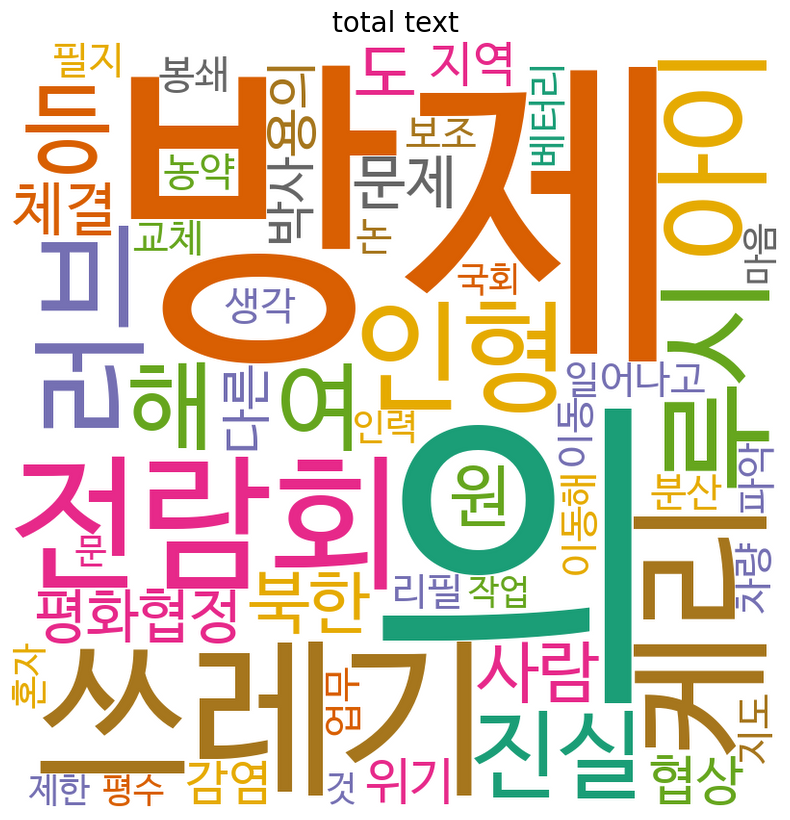

In [41]:
total_text = visualize(noun_list,'total text')

In [ ]:
#시간과 자원을 많이 잡아먹는관계로 valid 만 만들어보았습니다.